# 葉面の点群解析サンプルノートブック

## Colab利用者向け Open3Dのインストール

In [1]:
# Colabにはopen3dがインストールされていないので，マジックコマンドでインストールする．
!pip install open3d

     |████████████████████████████████| 4.6MB 7.1MB/s 


## パッケージの読み込み

In [3]:
import os, copy

import numpy as np
import scipy as sp
from sklearn.decomposition import PCA

# 可視化 Plotly
import plotly.graph_objs as go

# 点群解析 Open3D
import open3d as o3d

## 可視化用関数の定義
今回の解析に利用する関数を定義する．
Open3Dでも可視化用の関数がいくつか提供されているが，デフォルトではJupyter Notebook上からの呼び出しには対応していないので別の可視化用ライブラリPlotlyを利用する．


*   `plot_pc` 点群可視化用関数
*   `plot_mesh` メッシュ可視化用関数



In [4]:
# 点群可視化用関数
def plot_pc(pc, pc_color=None, pt_size = 1):
  # prep
  pc_type = type(pc)
  if pc_type is o3d.geometry.PointCloud:
    x,y,z = np.array(pc.points).transpose()
    if pc.has_colors():
      color = np.array(pc.colors)
    else:
      color = np.zeros((len(x),3))
  elif pc_type is np.ndarray:
    x,y,z = pc.transpose()
    if pc_color is not None:
      color = pc_color
    else:
      color = np.zeros((len(pc),3))
  else:
    print("Error")
    raise
  
  # plot
  fig = go.Figure(data=[go.Scatter3d(
      x=x, y=y, z=z,
      mode='markers', 
      marker={"color": color, "size":pt_size}
      )])
  fig.update_layout(
    scene = { "aspectmode": "data"}
    )
  # fig.show()
  return fig

# メッシュ可視化用
def plot_mesh(mesh, triangles = None,vertex_colors = None):
  # prep
  mesh_type = type(mesh)
  if mesh_type is o3d.geometry.TriangleMesh:
    x,y,z = np.array(mesh.vertices).transpose()
    i, j, k = np.array(mesh.triangles).transpose()
    if mesh.has_vertex_colors():
      color = np.array(mesh.vertex_colors)
    else:
      color = np.zeros((len(x),3))
  elif mesh_type is np.ndarray:
    x,y,z = mesh.transpose()
    if triangles is not None:
      i, j, k = triangles.transpose()
    if vertex_colors is not None:
      color = vertex_colors
    else:
      color = np.zeros((len(mesh),3))
  else:
    print("Error")
    raise


  # plot
  fig = go.Figure(data = [go.Mesh3d(
      x=x, y=y, z=z,
      i = i, j = j, k = k,
      vertexcolor = color
  )]
  )
  fig.update_layout(
    scene = { "aspectmode": "data"}
    )
  # fig.show()

  return fig


## データの読み込みと可視化

In [7]:
DIR_PATH = "/content/drive/My Drive/SSSB_2020_Noshita/leaves"
pcd = o3d.io.read_point_cloud(os.path.join(DIR_PATH, "points_dense_leaf_01.pcd"))

In [8]:
fig = plot_pc(pcd, pt_size = 0.5)
fig

Output hidden; open in https://colab.research.google.com to view.

## フィルター：背景除去
色（RGB値）で白に近い点を除去

In [9]:
filtered_idx = np.where(np.all(np.array(pcd.colors) < np.array([0.7, 0.7, 0.7]), axis=1))[0]
pcd_filtered = pcd.select_by_index(filtered_idx)

In [10]:
plot_pc(pcd_filtered)

Output hidden; open in https://colab.research.google.com to view.

In [11]:
labels = np.array(pcd_filtered.cluster_dbscan(eps=0.0005, min_points=5, print_progress=True))

In [12]:
max_label = labels.max()
colors = plt.get_cmap("tab20")(labels / (max_label if max_label > 0 else 1))
colors[labels < 0] = 0

pcd_cluster = o3d.geometry.PointCloud(pcd_filtered)
pcd_cluster.colors = o3d.utility.Vector3dVector(colors[:, :3])

In [13]:
cl, ind = pcd_filtered.remove_statistical_outlier(nb_neighbors=50,std_ratio=2)

In [14]:
plot_pc(pcd_filtered.select_by_index(ind))

Output hidden; open in https://colab.research.google.com to view.

In [ ]:
pcd_filtered = pcd_filtered.select_by_index(ind)

In [ ]:
o3d.io.write_point_cloud(os.path.join(DIR_PATH, "points_dense_leaf_02_filtered.pcd"), pcd_filtered)

True

## モデル化：葉面再構築

In [15]:
mesh, density = o3d.geometry.TriangleMesh.create_from_point_cloud_poisson(pcd_filtered)

In [16]:
plot_mesh(mesh)

Output hidden; open in https://colab.research.google.com to view.

(array([  141.,   201.,   383.,   400.,   570.,  1087.,   888.,   963.,
         3106., 36088.]),
 array([1.77133989, 2.36722555, 2.96311121, 3.55899687, 4.15488253,
        4.75076818, 5.34665384, 5.9425395 , 6.53842516, 7.13431082,
        7.73019648]),
 <a list of 10 Patch objects>)

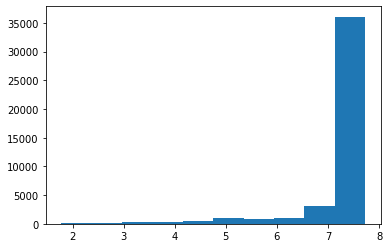

In [17]:
plt.hist(np.array(density))

In [18]:
density_arr = np.array(density)
vertices_to_remove = density_arr < 6.5
mesh.remove_vertices_by_mask(vertices_to_remove)

In [19]:
plot_mesh(mesh)

Output hidden; open in https://colab.research.google.com to view.

## 表現型値の推定：葉面積計測

In [24]:
mesh.get_surface_area()

0.00033820200838592207